# Kalman Filtering
## Tracking Location of an object moving with Constant velocity
We know the initial localtion and velocity of an object (e.g. a car) in a 2D space. We also have noisy measurements of the velocity as measured by the object itself. In this example it is assumed the velocity to be constant, altough not known to us. 

https://en.wikipedia.org/wiki/Kalman_filter

https://github.com/balzer82/Kalman/blob/master/Kalman-Filter-CA.ipynb?create=1


Simulate measurements of velocity. Assume constant velocity and noisy velocity measurements in two directions

In [18]:
import numpy as np
#Start from 0 position 
x0 = 0
y0 = 0
#x and y velocity (constant, 72Km/hour)
vx = 20
vy = 20
#Number of measurements
m = 100
#Add random noise to each constant velocity measurement
sigma_meas = 2
mvx = x0 + np.array(vx + np.random.randn(m) * sigma_meas)
mvy = y0 + np.array(vy + np.random.randn(m) * sigma_meas)
measurements = np.vstack((mvx,mvy))

Visualize the velocity measurements

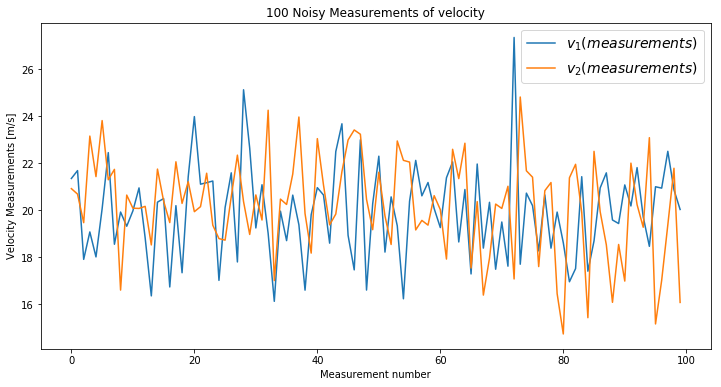

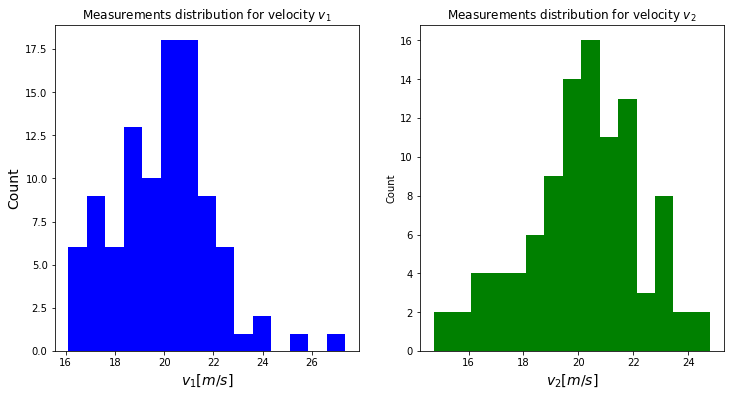

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.plot(range(m),mvx, label='$v_1 (measurements)$')
plt.plot(range(m),mvy, label='$v_2 (measurements)$')
plt.xlabel('Measurement number')
plt.ylabel('Velocity Measurements [m/s]')
plt.title('100 Noisy Measurements of velocity')
plt.legend(loc='best',prop={'size':14})
plt.show()
fig = plt.figure(figsize=(12, 6));
plt.subplot(121)
plt.hist(mvx,bins=15,color="blue")
plt.xlabel('$v_1 [m/s]$',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.title('Measurements distribution for velocity $v_1$')
plt.subplot(122)
plt.hist(mvy,bins=15,color="green")
plt.xlabel('$v_2 [m/s]$',fontsize=14)
plt.ylabel('Count')
plt.title('Measurements distribution for velocity $v_2$');

## Define the Kalman filter
Some definitions: 

* X$_t$ := state matrix;

* u$_t$ := control variable matrix;

* A := state-transition model applied to the previous state x<sub>t−1</sub>

* B := control-input model representing acceleration which is applied to the control vector u<sub>t</sub>

The algorithm updates this equation for the state matrix:  
  &nbsp;&nbsp;X$_t$ = A\*X<sub>t-1</sub> + B\*u<sub>t</sub> + Noise  
In the 2D case define with  
  &nbsp;&nbsp;X$_t$ := [x; y; ẋ; ẏ]  
  &nbsp;&nbsp;A := [1 0 dt 0;  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 1 0 dt;  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 0 1 0;  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 0 0 1]  
&nbsp;&nbsp;u<sub>t</sub> := [accelx;  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;accely]  
  &nbsp;&nbsp;B := [1/2\*dt^2  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;dt]

The first product in the state matrix equation above becomes:  
  &nbsp;&nbsp;A\*X$_t$ = [x+dt\*ẋ  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;y+dtẏ  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ẋ  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ẏ ]

The second product in the state matrix equation above becomes:  
&nbsp;&nbsp;B\*u<sub>t</sub> = [1/2\*dt<sup>2</sup>\*$accelx  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1/2\*dt<sup>2</sup>\*accely  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;dt\*accelx  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;dt\*accely]
 
Now calculate whole state matrix equation above:  
&nbsp;&nbsp;x<sub>t</sub>=x<sub>t-1</sub> + dt\*ẋ<sub>t-1</sub> + 1/2\*dt<sup>2</sup>\*accelx + noise, 

&nbsp;&nbsp;ẋ<sub>t</sub>=ẋ<sub>t-1</sub> + accelx\*dt + noise  
and similar for y and ẏ

In [3]:
# Time Step between measurements
dt = 0.1
# state matrix. start at 0 at 0 velocity
x = np.matrix([[x0, y0, 0.0, 0.0]]).T
# Error covariance matrix P (estimated accuracy of state estimate). It is P(k)=A(k)*P(k-1)*A(k)^T+Q(k)
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0])
# A matrix accounting for equations of motion. To define it take into account that A will be multiplied by [x, y, ẋ, ẏ], so: 
A = np.matrix([[1.0, 0.0, dt, 0.0], #This will lead to the component for the equation of motion:  1*x + dt*ẋ
               [0.0, 1.0, 0.0, dt],
               [0.0, 0.0, 1.0, 0.0], #0+ẋ
               [0.0, 0.0, 0.0, 1.0]]) #0+ẏ
# H matrix (used to make matrix products work)
# Identity matrix
I = np.eye(4)
H = np.matrix([[0.0, 0.0, 1.0, 0.0],
               [0.0, 0.0, 0.0, 1.0]])
# R matrix (measurement noise covariance)
r = 100.0
R = np.matrix([[r, 0.0],
               [0.0, r]])
# Q, G matrices. Q is process noise covariance and accounts for acceleration disturbance in our model
s = 8.8    #[m/s^2]. Noise on velocity measurement
G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [dt]])
Q = G*G.T*s**2

In [4]:
# The Following variables will store the results, at each iteration
xt = []
yt = []
dxt= []
dyt= []
Yx = []
Yy = []
Px = []
Py = []
Pdx= []
Pdy= []
Rdx= []
Rdy= []
Kx = []
Ky = []
Kdx= []
Kdy= []
#Predictions
xtp = []
ytp = []
dxtp = []
dytp = []
Pxp = []
Pyp = []
Pdxp = []
Pdyp = []
def savestates(xp, Pp, x, Y, P, R, K):    
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    Yx.append(float(Y[0]))
    Yy.append(float(Y[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Rdx.append(float(R[0,0]))
    Rdy.append(float(R[1,1]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    #Predictions
    xtp.append(float(xp[0]))
    ytp.append(float(xp[1]))
    dxtp.append(float(xp[2]))
    dytp.append(float(xp[3]))
    Pxp.append(float(Pp[0,0]))
    Pyp.append(float(Pp[1,1]))
    Pdxp.append(float(Pp[2,2]))
    Pdyp.append(float(P[3,3]))

In [11]:
K = (P*H.T) * np.linalg.pinv(denom)
print (P*H.T)
print denom
print K

[[ 11.05665445  -0.43434668]
 [ -0.43434668  11.05665445]
 [  6.72204017   5.72303918]
 [  5.72303918   6.72204017]]
[[ 106.72708054    5.71799881]
 [   5.71799881  106.72708054]]
[[ 0.10411434 -0.00964771]
 [-0.00964771  0.10411434]
 [ 0.06028358  0.05039337]
 [ 0.05039337  0.06028358]]


In [5]:
# Kalman Filtering Algorithm
for n in range(len(measurements[0])):
    # Prediction
    # state prediction
    xp = A*x  #No acceleration, B*u=0
    # error covariance prediction
    Pp = A*P*A.T + Q
    # Update Steps
    # Kalman Gain
    denom = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(denom)
    # Update the estimate via z
    Y = measurements[:,n].reshape(H.shape[0],1) #Y is the measurement. Often modeled as C*u+noise
    x = xp + K*(Y - H*x) #Use the Kalman Gain K to correct estimate x, 'balancing' measurement Y vs estimate H*x
    # error covariance
    P = (I - (K*H))*Pp
    #Alternatively use this formalism
    #Z = measurements[:,n].reshape(2,1)
    #y = Z - (H*x)  #Innovation or residual: output prediction error ie observed value at time t minus estimate
    #xp = xp + (K*y)
    
    # Storing results
    savestates(xp, Pp, x, Y, P, R, K)

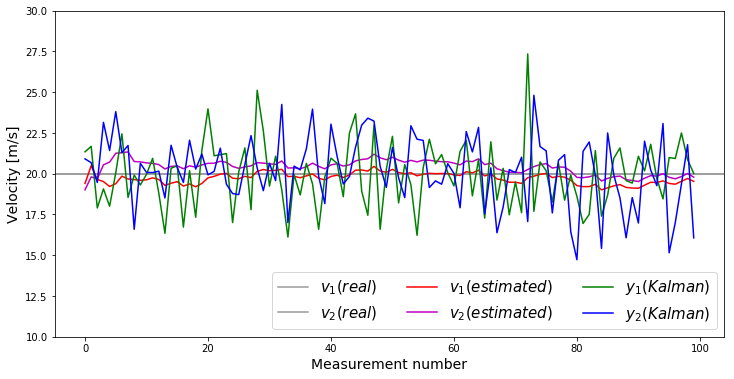

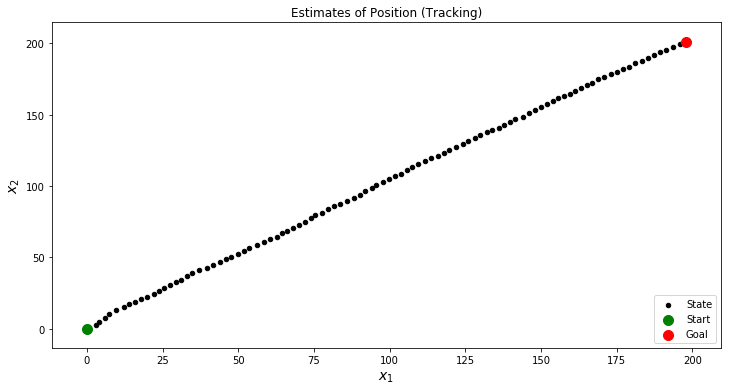

In [6]:
#Visualizing Results
#We can now visualize the results using the following lines of code in Python. 
# Velocity Measurements
fig = plt.figure(figsize=(12, 6))
# The actual constant velocity for both directions are in black
plt.axhline(vx, color='#999999', label='$v_1(real)$')
plt.axhline(vy, color='#999999', label='$v_2(real)$')
# Our estimates are in Red
plt.plot(range(m),dxt, label='$v_1 (estimated)$', c='r')
plt.plot(range(m),dyt, label='$v_2 (estimated)$', c='m')
# The noisy velocity measurements in both directions are in green and blue.
plt.plot(range(len(measurements[0])),mvx, label='$y_1 (Kalman)$', c='g')
plt.plot(range(len(measurements[0])),mvy, label='$y_2 (Kalman)$', c='b')
plt.xlabel('Measurement number',fontsize=14)
plt.ylabel('Velocity [m/s]',fontsize=14)
plt.legend(loc='lower right',ncol=3,prop={'size':15})
plt.ylim([10, 30])
plt.show()
# Position Tracking
# Scatter plot of x and y location estimates in black
# these should ideally form a straight line
fig = plt.figure(figsize=(12, 6))
plt.scatter(xt,yt, s=20, label='State', c='black')
# starting point in green and end point in red
plt.scatter(xt[0],yt[0], s=100, label='Start', c='g')
plt.scatter(xt[-1],yt[-1], s=100, label='Goal', c='r')
plt.xlabel('$x_1$',fontsize=14)
plt.ylabel('$x_2$',fontsize=14)
plt.title('Estimates of Position (Tracking)')
plt.legend(loc='lower right',)
plt.show()


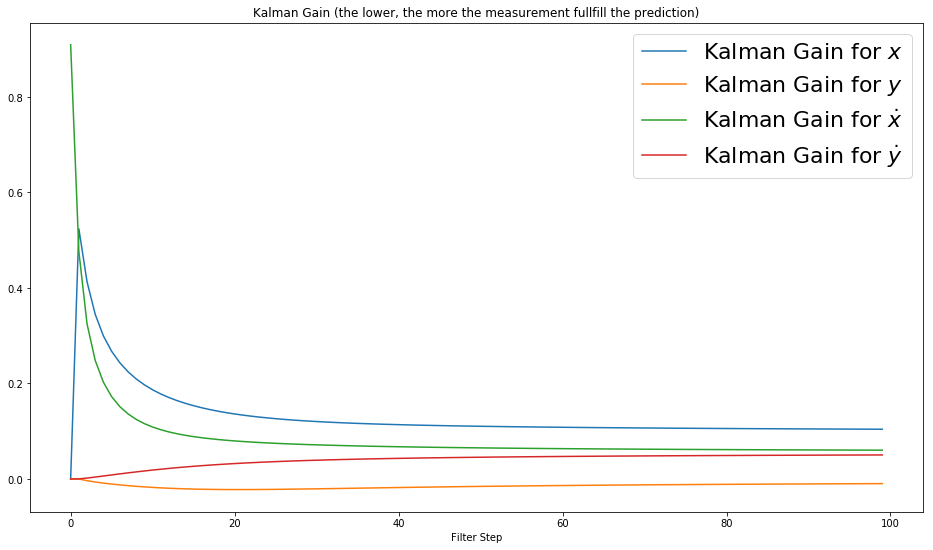

In [7]:
#Kalman Gains $K$
def plot_K():
    fig = plt.figure(figsize=(16,9))
    plt.plot(range(m),Kx, label='Kalman Gain for $x$')
    plt.plot(range(m),Ky, label='Kalman Gain for $y$')
    plt.plot(range(m),Kdx, label='Kalman Gain for $\dot x$')
    plt.plot(range(m),Kdy, label='Kalman Gain for $\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
    plt.legend(loc='best',prop={'size':22})
plot_K()

In [8]:
#Show the result for 
import pandas as pd
pd.DataFrame(np.column_stack([pd.Series(range(m))*dt, xtp, Pxp, Yx, Kx, xt, Px, np.ones(100)*vx]),
            columns=['t','$X_t$ on prediction','Px on prediction','Yx','Kx','$X_t$ on update','Px on update','Truth'])


,t,$X_t$ on prediction,Px on prediction,Yx,Kx,$X_t$ on update,Px on update,Truth
0,0.0,0.000000,1010.001936,21.343951,0.000000,0.000000,1010.001936,20.0
1,0.1,1.940359,1021.826982,21.679129,0.523819,3.132345,1012.277183,20.0
2,0.2,5.181139,1019.825458,17.901360,0.412814,4.114602,1013.885779,20.0
3,0.3,6.079390,1019.770150,19.068266,0.344521,5.857769,1015.273226,20.0
4,0.4,7.809586,1020.263308,18.005573,0.299382,7.349174,1016.554505,20.0
5,0.5,9.270935,1020.982314,20.056998,0.267300,9.462506,1017.775080,20.0
6,0.6,11.401365,1021.814813,22.444689,0.243246,12.144305,1018.957268,20.0
7,0.7,14.129507,1022.712112,18.543990,0.224490,13.829745,1020.113573,20.0
8,0.8,15.797687,1023.649972,19.915453,0.209428,15.919787,1021.251651,20.0
9,0.9,17.883632,1024.615093,19.311018,0.197059,17.820925,1022.376492,20.0
